
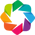

In [2]:
import matplotlib
import poloniex
import datetime
import holoviews as hv
import pandas as pd
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh')

In [3]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=364)
ether = poloniex.get_ohlc('USDT_ETH',start, end)
btc = poloniex.get_ohlc('USDT_BTC', start,end)

In [5]:
ether.describe()

close           high            low           open  \
count  104832.000000  104832.000000  104832.000000  104832.000000   
mean      148.143762     148.544564     147.727612     148.150145   
std       130.759833     131.089946     130.413558     130.768600   
min         5.883966       5.964728       5.854031       5.900000   
25%        11.337966      11.350000      11.325248      11.339417   
50%        92.006915      92.262706      91.803360      92.013965   
75%       291.123230     291.900000     290.455092     291.197566   
max       405.000000     408.128700     395.800000     405.000000   

         quoteVolume        volume  weightedAverage  
count  104832.000000  1.048320e+05    104832.000000  
mean      203.618733  3.349591e+04       148.133492  
std       463.405426  8.086008e+04       130.748531  
min         0.000000  0.000000e+00         5.900298  
25%         6.593947  1.863158e+02        11.339357  
50%        53.590863  6.212394e+03        92.023368  
75%       199.019343  3.094151e+04       291.146783  
max     13335.125868  2.630736e+06       399.911100

In [4]:
btc.tail()

close         high          low         open  \
date                                                                      
2017-11-18 12:55:00  7700.000000  7718.271449  7690.000001  7710.000001   
2017-11-18 13:00:00  7734.999000  7735.134000  7688.000000  7700.000000   
2017-11-18 13:05:00  7721.089271  7735.832000  7712.038472  7730.000000   
2017-11-18 13:10:00  7725.000000  7737.815425  7706.971100  7719.939594   
2017-11-18 13:15:00  7730.999999  7733.000000  7719.797829  7725.000000   

                     quoteVolume         volume  weightedAverage  
date                                                              
2017-11-18 12:55:00     5.641699   43446.572957      7700.972654  
2017-11-18 13:00:00    13.550694  104401.583874      7704.519297  
2017-11-18 13:05:00    12.672913   97895.456482      7724.779453  
2017-11-18 13:10:00    13.420821  103779.501604      7732.723572  
2017-11-18 13:15:00     2.904309   22430.555218      7723.197648

In [6]:
def load_symbol(symbol, **kwargs):
    df = data[symbol]
    df.reset_index(level=0, inplace=True)
    return hv.Curve(df, ('date', 'Date'), ('close', 'Close price'))

stock_symbols = ['ETH', 'BTC',]
data = {"ETH": ether, 'BTC':btc}
dmap = hv.DynamicMap(load_symbol, kdims='Symbol').redim.values(Symbol=stock_symbols)

In [9]:
%%opts Curve [width=700] {+framewise}
dmap

:DynamicMap   [Symbol]
   :Curve   [date]   (close)

In [10]:
%%opts Scatter [width=700] (color='black')
smoothed = dmap*rolling(dmap, rolling_window=30)*rolling_outlier_std(dmap)
smoothed

:DynamicMap   [Symbol]

### Rolling correlation

Let's look at rolling correlations but only for the last 1000 prices.

In [15]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_corr(w, **kwargs):
    S = ether['close'].rolling(w).corr(other=btc['close'])
    ether['corrBTC'] = S
    ether['date'] = ether.index

    return hv.Curve(ether.iloc[-1000:], ('date', 'Date'), ('corrBTC','Rolling correlation'))
    
winsize = {s:rolling_corr(s) for s in range(10,60,2)}
rcorr = hv.HoloMap(winsize, kdims='Window size')
rcorr

:HoloMap   [Window size]
   :Curve   [date]   (corrBTC)

## Volatility

In [9]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def rolling_vol(w, symbol):
    dt = data[symbol]
    S = dt['close'].rolling(w).std()
    dt['Volatility'] = S
    dt['date'] = ether.index

    return hv.Curve(dt.iloc[-1000:], ('date', 'Date'), ('Volatility','Rolling volatility'))

stock_symbols = ['ETH', 'BTC',]
data = {"ETH": ether, 'BTC':btc}    
winsize = range(10,60,2)
rvol = hv.DynamicMap(rolling_vol, kdims=['Wsize', 'Symbol']).redim.values(Symbol=stock_symbols).redim.range(Wsize=(10,60))
rvol

:DynamicMap   [Wsize,Symbol]